# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

[](#sec1)

### Откройте файл с данными и изучите общую информацию. <a id='#sec1'></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


В датафрейме 23699 строк, 22 столбца. Много столбцов с пропущенными значениями. В стобце first_day_exposition, тип данных - object, более практично будет изменить на datetime.

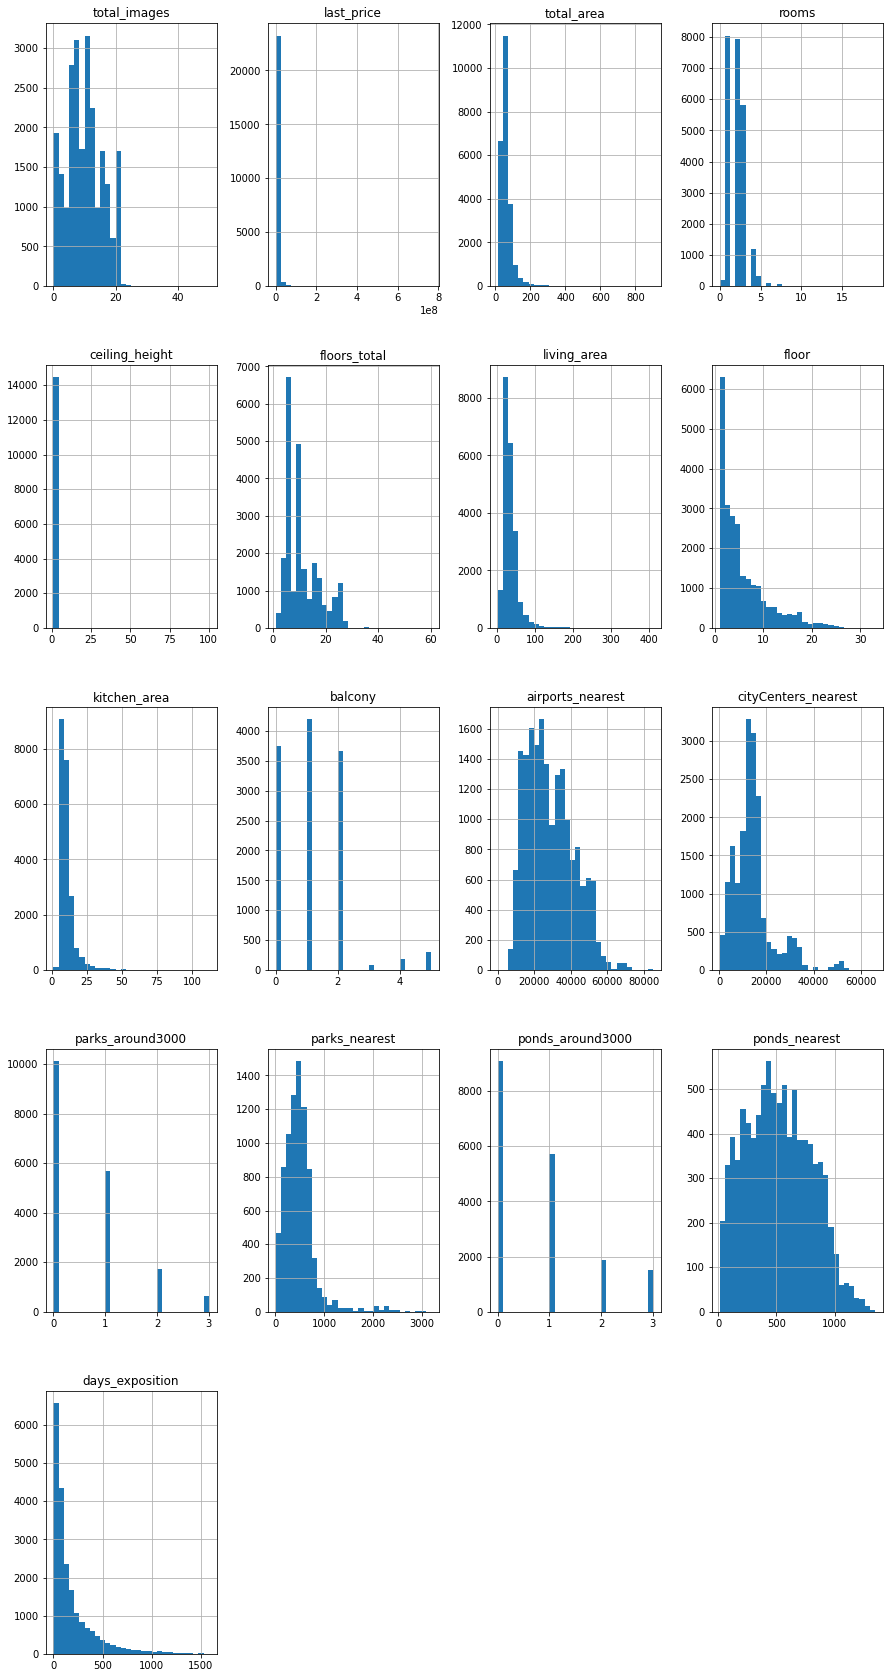

In [3]:
data.hist(figsize=(15, 30), bins=30);

<AxesSubplot:>

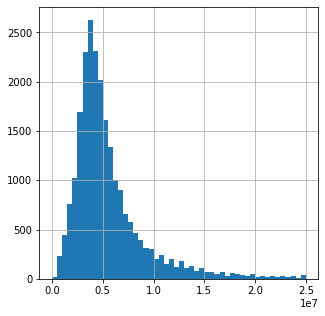

In [4]:
""" За единицу по оси Х принята сумма в 10 млн. Ограничил максимальный диапазон стоимости числом 25 млн,
    сузив максштаб просмотра, так как при указании реального максимума в 763 млн будет не показательный график"""
data.last_price.hist(figsize=(5, 5), bins=50, range=(data.last_price.min(), 25000000))
#data.last_price.max() # Вывод максимальной стоимости объекта из датафрейма

<AxesSubplot:>

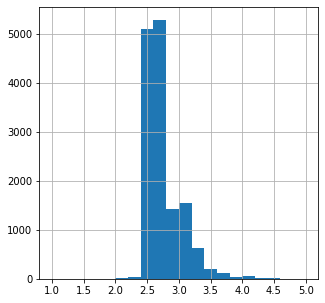

In [5]:
data.ceiling_height.hist(figsize=(5, 5), bins=20, range=(data.ceiling_height.min(), 5))

По итогам построенных гистограмм: два графика (ceiling_height и last_price) были не репрезентативны. После корректировки параметра range, получились более покательные графики. 

### Предобработка данных

In [6]:
# Знакомимся с уникальными значениями столбца ceiling_height, выявляем аномалии
data.ceiling_height.sort_values().unique()
# Получилось 39 строк с высотой потолков свыше 5 метров, случаи где высота равна 25, 32 и подобное, 
# будем корректировать на 2.5, 3.2. Остальное рассматриваем как выбросы и удаляем 
data[(data['ceiling_height'] > 5) | (data['ceiling_height'] < 2)].sort_values('ceiling_height') 
# Приводим данные типа 25 метров к 2.5 метров
data.loc[data['ceiling_height'] > 20, 'ceiling_height'] /= 10 
# оставляем потолки между 2.4 и 5 метрами.
data = data[~(data['ceiling_height'] > 5) | (data['ceiling_height'] < 2.4)]
# Анализируем минимальные цены недвижимости
data.sort_values("last_price").head(15)
# Удалим строку с минимальной ценой за квартиру, цена явно ошибочна (12190р за 109 кв/м в СПБ)
data.drop(data['last_price'].idxmin(), inplace=True)
# Обнаружил квартиры с количеством комнат == 0, но это не студии. Таких 59 позиций. Одна 371 кв.метр, остальные меньше 40
data[(data['studio'] == False) & (data['rooms'] == 0)]
# Заменим количество комнат у жилья размером 371 кв.метр на 5
data.loc[19392, 'rooms'] = 5
# Заменим количество комнат у квартир 40 метров на 1.
data.loc[(data['studio'] == False) & (data['rooms'] == 0), :] = 1

In [7]:
mean_living_to_total = round(data["living_area"].mean()/data["total_area"].mean(), 2)
mean_kitchen_to_total = round(data["kitchen_area"].mean()/data["total_area"].mean(), 2)
print(f'Среднeе соотношение жилой площади к площади квартиры: {mean_living_to_total}')
print(f'Среднeе соотношение жилой площади к площади квартиры: {mean_kitchen_to_total}')

Среднeе соотношение жилой площади к площади квартиры: 0.57
Среднeе соотношение жилой площади к площади квартиры: 0.17


Для дальшего заполнение пропусков, вычислил среднее соотношение жилой площади к размеры квартиры и кухни к размеру квартиры.

Отредактировал выбросы по колонкам ceiling_height, last_price, rooms.

In [8]:
# Nan в ceiling_height заменяем медианой по столбцу
data['ceiling_height'].fillna(data['ceiling_height'].median(), inplace=True) 
# Заменяем Nan в floors_total медианой
data.floors_total.unique()
data['floors_total'].fillna(data['floors_total'].median(), inplace=True)
#Обнаружил данные (4 ряда) в которых жилая площадь меньше 4 кв метров
data.query('living_area < 7').sort_values('living_area')  
data['living_area'].fillna(data['living_area'] * mean_living_to_total, inplace=True)
# Убрал строки где living_area < 4, эти данные были странными (например была общая площадь 130 кв. из них 2 кв жилое) 
data = data.query('living_area > 4')
# Много пропущенных значений в is_apartment выяснил,что соотношение True к False =  2 % (False 2724, True  49)  
data.groupby('is_apartment')['is_apartment'].count()  
# Заполнил 2% - True, 98% - False. 23699 - изначальный размер таблицы
data['is_apartment'].fillna(pd.Series(np.random.choice([True, False], 23699, p=[0.02, 0.98])) , inplace=True) 
# Заменил пропущенные значения на среднее выборочное соотношение кухни к размеру жилья
data['kitchen_area'].fillna(data['total_area'] * mean_kitchen_to_total, inplace=True)
# Будем считать, что пропущеное значение по балконам это отсутствие балкона.
data['balcony'].fillna(0, inplace=True)
columns_to_fill = ['locality_name', 'airports_nearest', 'parks_around3000', 'ponds_around3000', 'ponds_nearest']
data[columns_to_fill] = data[columns_to_fill].fillna('Неизвестно')

In [9]:
""" Произвел проверку на превышение этажа квартиры над этажностью дома, 
    обнаружилось 37 строк, заменяем такие случаи на максимальный этаж в доме"""
data[data['floors_total'] < data['floor']].shape
data.loc[data['floors_total'] < data['floor'], 'floor'] = data['floors_total']

Отбработал все пропущенные значения. Все пропущенные значения кажутся результатом человеческого фактора, где-то значения были внесены некорректно, где-то были пропущены возможно из-за нежелания заполнять лишние позиции, вроде наличия балконов.

In [10]:
# Проверяем на явные дубликаты. Не обнаружилось
data.duplicated().sum()
# Редактируем неявные дубликаты: «поселок Рябово» и «поселок городского типа Рябово» и т.д. 
data.loc[data['locality_name'].str.contains('Рябово'), 'locality_name'] = 'посёлок городского типа Рябово'
data.loc[data['locality_name'].str.contains('Рощино'), 'locality_name'] = 'поселок городского типа Рощино'
data.loc[data['locality_name'].str.contains('Лесное'), 'locality_name'] = 'поселок Лесное'
data['locality_name'] = (data['locality_name'].str.replace('ё', 'е')) 

Явные дубликаты не обнаружились. Заменил 'ё' на 'е', тем самым убрал часть неявных дубликатов. Часть неявных дубликатов нашел с помошью функции глаза.поиск(внимательность = 'низкая').

In [11]:
# Приводим тип данных first_day_exposition к datetime
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'])
data['balcony'] = data['balcony'].astype(int)
data['floor'] = data['floor'].astype(int)

Поменял тип данных чтобы, при необходимости, можно было сравнивать их между собой операторами >, < или ==. Или использвать методы dt.

### Посчитайте и добавьте в таблицу новые столбцы

In [12]:
data['per_metr_price'] = round(data['last_price']/data['total_area'], 2)
data['day'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

def floor_type(data):
    if data['floor'] == 1:
        return 'первый'
    elif data['floor'] == data['floors_total']:
        return 'последний'
    else:
        return 'другой'
    
data['floor_type'] = data.apply(floor_type, axis=1)

def km_to_cenre(data):
    if data['cityCenters_nearest'] == np.nan:
        pass
    else:
        return data['cityCenters_nearest']/1000

data['km_to_cenre'] = data.apply(km_to_cenre, axis=1)

Добавлены столбцы со стоимостью квадратного метра, номером дня, недели и годом. Так же реализована функция возвращающая тип этажа, для нового столбца. Реализована функция возвращающая расстояние в киллометрах, для нового столбца.

### Проведите исследовательский анализ данных

In [13]:
data2 = data.copy()
data2 = data[(data['rooms'] < 6)]
data2 = data2[data2['total_area'] <= 120]
data2 = data2[data2['last_price'] <= 15000000]
print(f'Соотношение новой таблицы к старой: {round(data2.shape[0] / data.shape[0], 2)}') 
data = data2


Соотношение новой таблицы к старой: 0.94


Отбросил слишком большие значения. Ограничил количество rooms, total_area, last_price

Text(0, 0.5, 'Количество')

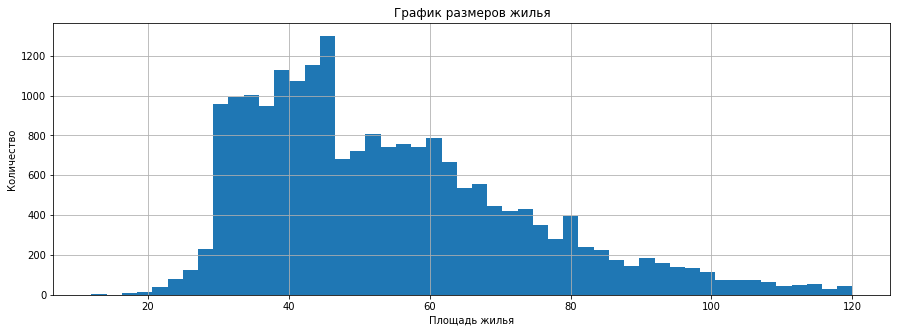

In [14]:
""" Устраним выбросы используя стандартное отклонение.
    При больнем количестве станд. отклонений график удлиняется вправо без особой пользы.
    upper_line = data['total_area'].mean() + data['total_area'].std() * 1.5
    data_no_outlier = data[data['total_area'] < upper_line]
    data[data['total_area'] < upper_line].shape[0] / data.shape[0] # Получается 0.945, upper_line = 112.07 """
area_plot = data.total_area.plot(kind='hist', bins=50, figsize=(15,5), grid=True, title='График размеров жилья')
area_plot.set_xlabel('Площадь жилья')
area_plot.set_ylabel('Количество')


Больше всего предложений жилья представленно в диапазоне до 50 квадратный метров. Меньше предложений от 50 до 80. Предложение жилья от 80 метров, снижается с ростом площади и стремится к нулю. Пик предложений находится в районе 45 метров. Второй по высоте пик в райне 30 метров. (Напоминает хрущевки - 33 кв метра 1 комнатные и 45 метров 2 комнатные)

Text(0, 0.5, 'Количество')

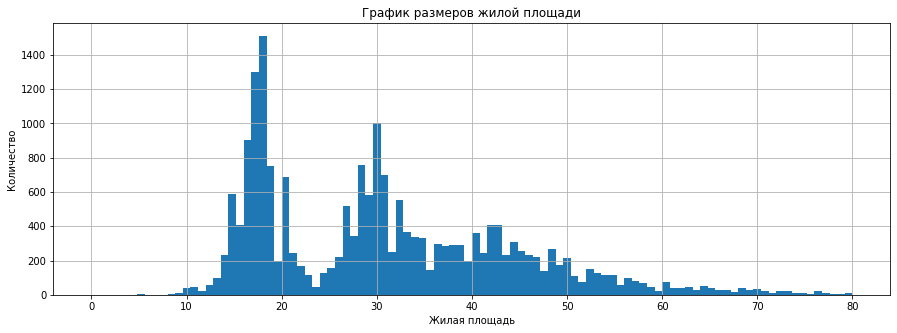

In [15]:
size_plot = data.living_area.plot(kind='hist', bins=100, figsize=(15,5), range=(0, 80), grid=True, title='График размеров жилой площади')
size_plot.set_xlabel('Жилая площадь')
size_plot.set_ylabel('Количество')

На графике виден сильный пик в районе 30 метров, второй по высоте пик это около 18 метров. 

Text(0, 0.5, 'Количество')

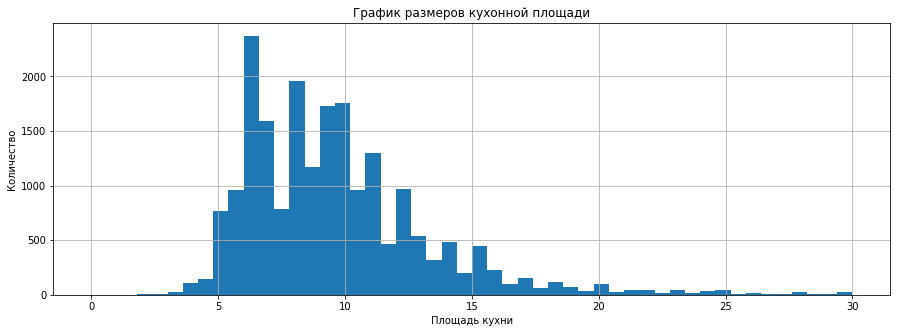

In [16]:
kitchen_plot = data.kitchen_area.plot(kind='hist', bins=50, figsize=(15,5), range=(0, 30), grid=True, title='График размеров кухонной площади')
kitchen_plot.set_xlabel('Площадь кухни')
kitchen_plot.set_ylabel('Количество')

Основная масса наблюдений расположена от 5 до 15 метров, с тремя сильно выделяющимися пиками: в районе 6 метров, чуть ниже в районе 8 метров, и ниже в районе 10 метров.

Text(0, 0.5, 'Количество')

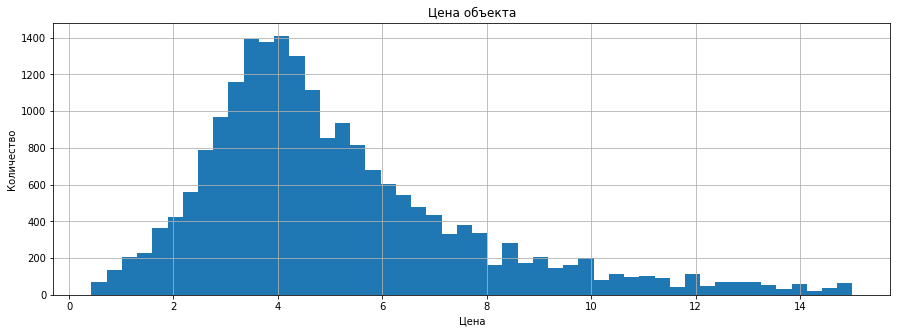

In [17]:
""" Устраним выбросы используя стандартное отклонение.
    При большем количестве станд. отклонений график удлиняется вправо без особой пользы.
    upper_line = data.last_price.mean() + data.last_price.std()
    data_no_outlier = data[data.last_price < upper_line]
    data_no_outlier.shape[0] / data.shape[0] # Получается 0.962, upper_line = 17284922.36 """
price_new = pd.Series(data2.last_price / 1000000)
price_plot = price_new.plot(kind='hist', bins=50, figsize=(15,5), grid=True, title='Цена объекта')
price_plot.set_xlabel('Цена')
price_plot.set_ylabel('Количество')

Больше всего объектов имеют стоимость около 3,9 млн. рублей. Самый насыщенный предложением ценовой диапазон это от 3 до 5 млн. рублей. Количество предложений свыше 5 млн. постепенно уменьшается.

Text(0, 0.5, 'Количество')

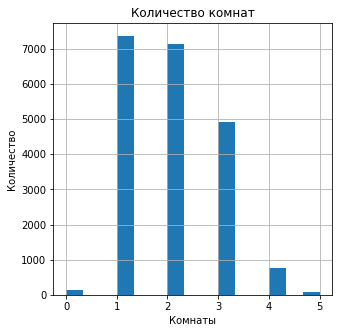

In [18]:
   """ old_rooms = data.shape[0]
    new_rooms = data[data.rooms < 6].shape[0]
    new_rooms/old_rooms # Получается соотношение 0.99 """
rooms_plot = data.rooms.plot(kind='hist', bins=15, figsize=(5,5), range=(0,5), grid=True, title='Количество комнат')
rooms_plot.set_xlabel('Комнаты')
rooms_plot.set_ylabel('Количество')

Больше всего на рынке однокомнатных квартир (чуть более 8 тысяч). Второе место занимают двухкомнатные квартиры (около 7.9 тысяч). На тертьем месте трехкомнатные квартиры (около 5.8 тысяч). Количество четырехкомнатных квартир сильно отстает (около 1.2 тысяч). В дальнейшем с ростом комнат количество предложений сокращается. Так же на графике заметно небольшой количество студий (около 200 тыс.)

Text(0, 0.5, 'Количество')

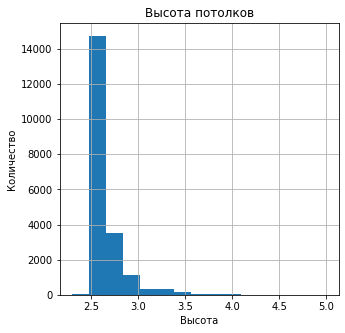

In [19]:
cel_plot = data.ceiling_height.plot(kind='hist', bins=15, figsize=(5,5), range=(2.3, 5), grid=True, title='Высота потолков')
cel_plot.set_xlabel('Высота')
cel_plot.set_ylabel('Количество')

Подавляющее большинство потолков - 2.5 метра. Второй пик - 2.75 метров. Третий пик - 3 метра. Далее высота сокращается.

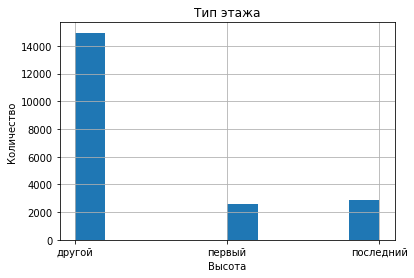

In [20]:
plt.hist(data.floor_type)
plt.title('Тип этажа')
plt.xlabel('Высота')
plt.ylabel('Количество')
plt.gca().xaxis.grid(True)
plt.gca().yaxis.grid(True)

Большинство квартир находятся не на крайних этажах (около 17.5 тысяч). Около 3 тысяч квартир находятся на последнем этаже. Около 2750 тысяч квартир на первом.

Text(0, 0.5, 'Количество')

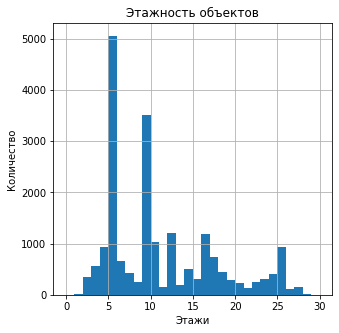

In [21]:
height_plot = data.floors_total.plot(kind='hist', bins=30, figsize=(5,5), range=(0, 30), grid=True, title='Этажность объектов')
height_plot.set_xlabel('Этажи')
height_plot.set_ylabel('Количество')

Заметное большинство объектах находится в пятиэтажных домах (около 5800 объектов). На втором месте количество предложений в девятиэтажных домах (около 3800). 

Text(0, 0.5, 'Количество')

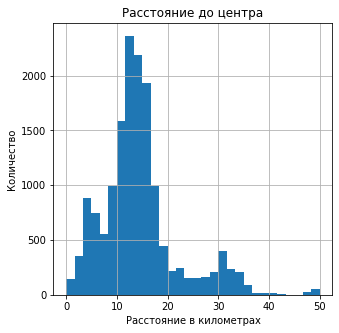

In [22]:
centre_plot = data.km_to_cenre.plot(kind='hist', bins=30, figsize=(5,5), range=(0, 50), grid=True, title='Расстояние до центра')
centre_plot.set_xlabel('Расстояние в километрах')
centre_plot.set_ylabel('Количество')

Большинство объектов находится на расстоянии 15 километров от центра. Самый плотный диапазон это 10 - 18 километров от центра. В нем находится около половины всех объектов. 

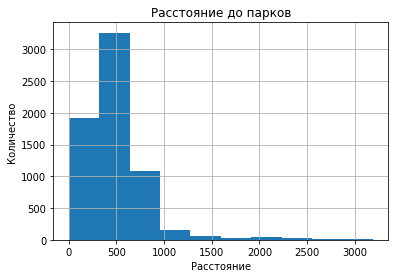

In [23]:
plt.hist(data.parks_nearest)
plt.title('Расстояние до парков')
plt.xlabel('Расстояние')
plt.ylabel('Количество')
plt.gca().xaxis.grid(True)
plt.gca().yaxis.grid(True)

Большинство объктов жилья находится на расстоянии 500 метров от парка. Подавлющее большинство жилья находится на расстоянии до 1000 метров от парка.

In [24]:
print(f'Средний срок продажи жилья равен: {int(data.days_exposition.mean())} день')

Средний срок продажи жилья равен: 178 день


In [25]:
print(f'Медиана по сроку продажи жилья равна: {int(data.days_exposition.median())} дней')

Медиана по сроку продажи жилья равна: 98 дней


Text(0, 0.5, 'Количество')

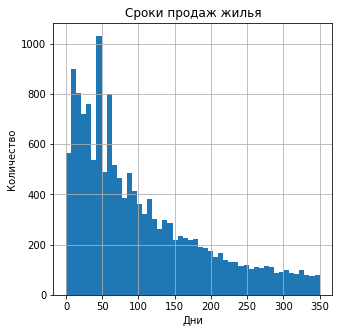

In [26]:
expose_plot = data.days_exposition.plot(kind='hist', bins=50, figsize=(5,5), range=(0, 350), grid=True, title='Сроки продаж жилья')
expose_plot.set_xlabel('Дни')
expose_plot.set_ylabel('Количество')

Большинство жилья продается в первые 200 дней. Затем идет понижательное направление графика. Есть сильный всплеск закрытых объявлений около 45 и 60 суток экспозиции. 

<AxesSubplot:>

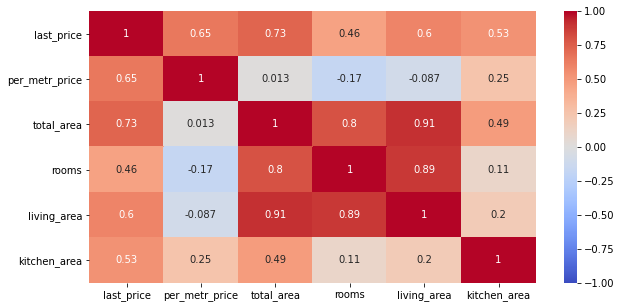

In [27]:
# Определяем размер тепловой карты
fig, ax = plt.subplots(figsize=(10, 5))
# Создаем тепловую карту по корреляции параметров
filtered_data = data[['last_price', 'per_metr_price', 'total_area','rooms','living_area', 'kitchen_area']]
sns.heatmap(filtered_data.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

Целью данного графика было найти корреляцию между даными. Нас интересует корреляция с ценой объекта. Самая высокая связь (0.73) между общей площадью и ценой. На втором месте (0.65) между ценой метра квадратного и общей ценой. Далее идут связи между жилой площадью(0.6), площадью кухни(0.53). Стоимость квадратного метра имеет втрою по уровню корреляцию с размером площади кухни (0.24)

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

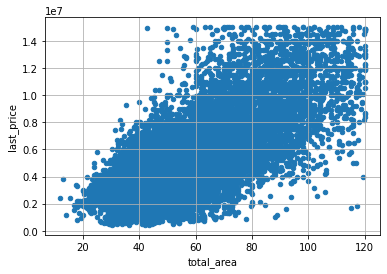

In [28]:
data.plot.scatter(x='total_area', y='last_price', grid=True)

Видна сильная корреляция общей цены квартиры и общей площади. Что, конечно, логично.

<AxesSubplot:xlabel='living_area', ylabel='last_price'>

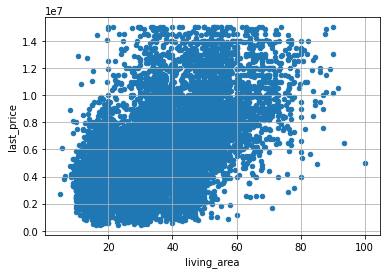

In [29]:
data.plot.scatter(x='living_area', y='last_price', grid=True)

Корреляция слабее чем в предыдущем примере, но она явно положительна, в целом рост жилой площади дает рост цены квартиры, хотя пропорция не прямая.

<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

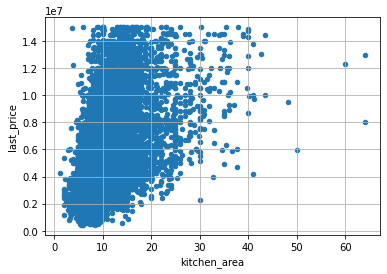

In [30]:
data.plot.scatter(x='kitchen_area', y='last_price', grid=True)

Слабая зависимость цены от размера кухни. Но все таки не нулевая, видно что с ростом размера кухни цена жилья скорее растет. Больше ситуаций в которыхцена жилья растет, при том аналогичном размере кухни, значит размер кухни слабо влияет на рост стоимости жилья.

<AxesSubplot:xlabel='rooms'>

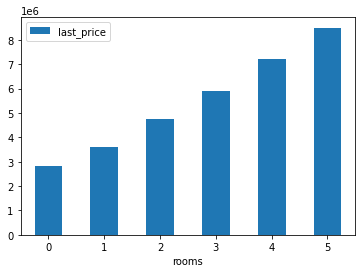

In [31]:
data.pivot_table(index='rooms', values='last_price', aggfunc='median').plot(kind='bar', rot=0)

Видим что при росте комнатности квартиры логично растет и стоимость жилья, с ростом комнатности растет размер квартиры, выраженный в общем количестве квадратных метров.

<AxesSubplot:xlabel='rooms'>

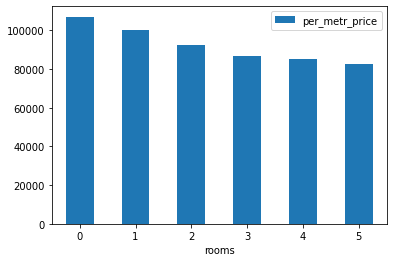

In [32]:
data.pivot_table(index='rooms', values='per_metr_price', aggfunc='median').plot(kind='bar', rot=0)

График показывает нам, что чем меньше комнатность и с высокой вероятностью площадь квартиры, тем выше стоимость квардратного метра. 

<AxesSubplot:xlabel='floor'>

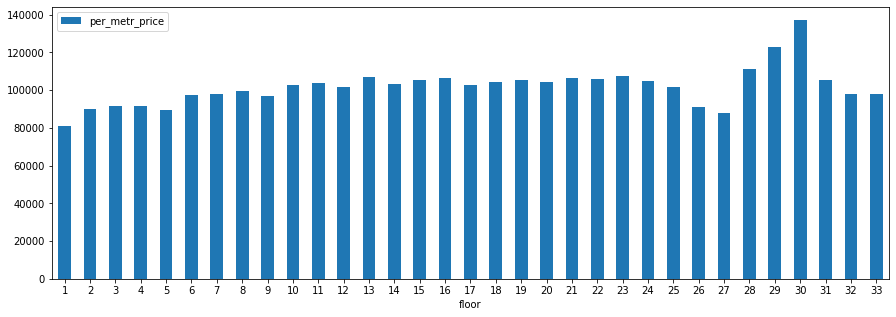

In [33]:
data.pivot_table(index='floor', values='per_metr_price', aggfunc='median').plot(kind='bar',figsize=(15,5),  rot=0)

График показывает нам что в основном цена кв. метра квартир до 5 этажей ниже чем на 9 этажах. В свою очередь кв. метр на 9 этажнах стоит ниже чем на более высоких. Особо высоко жители Петербурга ценят жилье на 29 и 30 этажах, разница в ценах с квартирами прочей высотности порядка 10-15 процентов.

<AxesSubplot:xlabel='floor'>

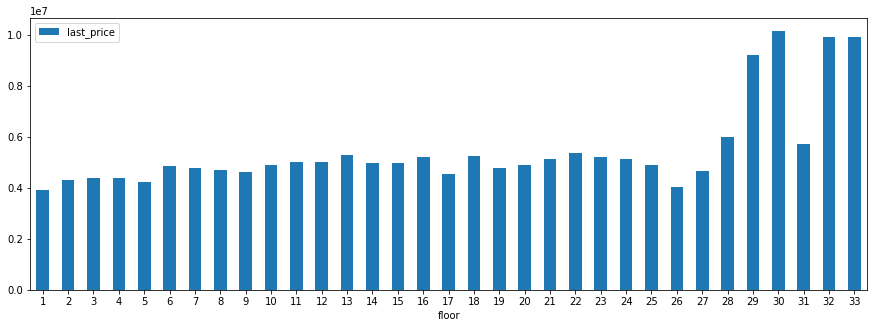

In [34]:
data.pivot_table(index='floor', values='last_price', aggfunc='median').plot(kind='bar',figsize=(15,5),  rot=0)

В данном случае наблюдаем плавный и небольшой рост общей стоимости жилья связанный с ростом этажа квартиры. После 28 этажа виден резких рост стоимости квартир на любимых жителями города на Неве 29, 30 этажах, так же в фавориты попадают 32 и 33 этажи. Несправдливо в стороне остается 31 этаж. В целом это скорее всего видовые квартиры, которые имеют более высокую ценность. Более низкая цена 31 этажа скорее всего связана с малым количеством наблюдений.

<AxesSubplot:xlabel='day'>

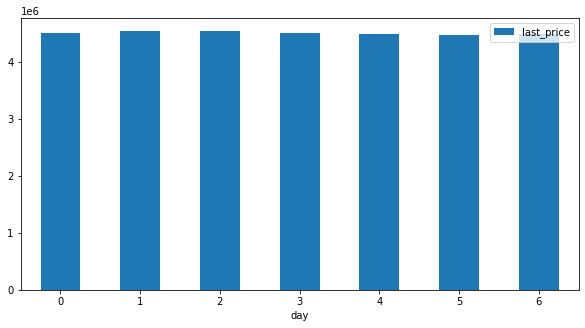

In [35]:
data.pivot_table(index='day', values='last_price', aggfunc='median').plot(kind='bar',figsize=(10,5),  rot=0)

День размещения объвления не влияет на цену квартиры.

<AxesSubplot:xlabel='month'>

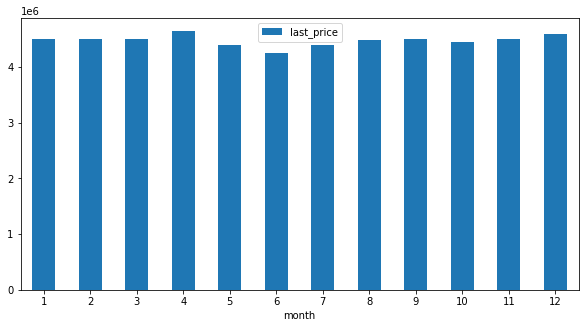

In [36]:
data.pivot_table(index='month', values='last_price', aggfunc='median').plot(kind='bar',figsize=(10,5),  rot=0)

Плавный и небольшой рост стоимости жилья до апреля, с дном в июне, далее планый небольшой рост. В целом можно сказаь, что квартиры летом выставляют чуточку дешевле чем в остальные сезоны.

<AxesSubplot:xlabel='year'>

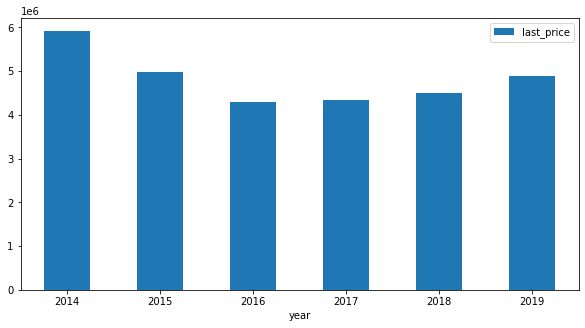

In [37]:
data.pivot_table(index='year', values='last_price', aggfunc='median').plot(kind='bar',figsize=(10,5),  rot=0)

В 2014 году квартиры в целом стоили выше чем в последующие пять лет. С 2017 рост цен на жилье постепенно пролжился. 

<AxesSubplot:xlabel='year'>

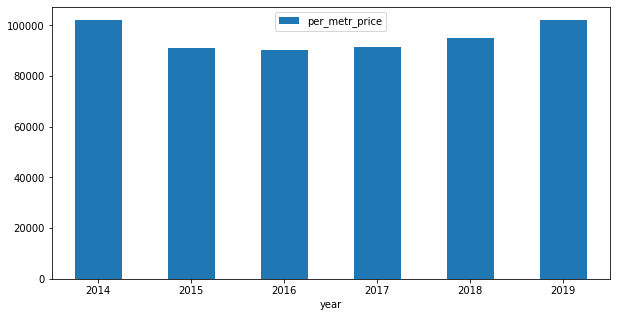

In [38]:
data.pivot_table(index='year', values='per_metr_price', aggfunc='median').plot(kind='bar',figsize=(10,5),  rot=0)

После 2014 года происходит снижение стоимости квадратного метра, с дном в 2016 году и восстановлением до уровней 2014 года в 2019 году.

In [39]:
pivot_table = data.pivot_table(index='locality_name', values=['per_metr_price'], aggfunc={'mean','count'})
pivot_table.columns = ['count', 'mean']
pivot_table['mean'] = pivot_table['mean'].round() # Округлим значения
pivot_table.sort_values('mean', ascending=False).head(10)

,count,mean
locality_name,,
Санкт-Петербург,13281,107327.0
Зеленогорск,21,102890.0
Пушкин,321,101744.0
Сестрорецк,158,100931.0
Кудрово,162,100590.0
деревня Мистолово,9,93294.0
деревня Кудрово,250,92528.0
Мурино,32,92144.0
поселок Парголово,298,90462.0


Согласно сводной таблице лидеров по стоимости жилья в Ленинградской области является Санкт-Петербург со среденей ценой метра в 107327 р., замыкаеют десятку самых дорогих городов объекты с пропущенным названием населенного пункта со средней ценой квадратного метра в 89581 р.

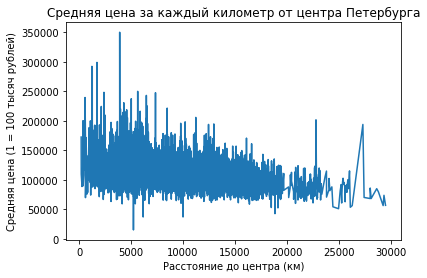

In [40]:
spb = data[data['locality_name'] == 'Санкт-Петербург']

pivot_table = spb.pivot_table(index='cityCenters_nearest', values='per_metr_price', aggfunc='mean')

# Построение графика с использованием seaborn
sns.lineplot(x=pivot_table.index, y='per_metr_price', data=pivot_table,)

# Настройка заголовка и меток осей
plt.title('Средняя цена за каждый километр от центра Петербурга')
plt.xlabel('Расстояние до центра (км)')
plt.ylabel('Средняя цена (1 = 100 тысяч рублей)')

plt.show()

График показывает нам зависимость цены за метр от расстояния до центра. Самые дорогие объекты находятся на расстоянии 1-2 километров от центра. С пиком около 5,5 километров. После 8 километров от центра идет постепенное снижение стоимости квадратного метра.

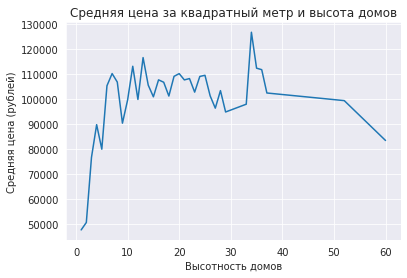

In [41]:
pivot_table = data.pivot_table(index='floors_total', values='per_metr_price', aggfunc='mean')

sns.set_style("darkgrid")
# Построение графика с использованием seaborn
sns.lineplot(x=pivot_table.index, y='per_metr_price', data=pivot_table)

# Настройка заголовка и меток осей
plt.title('Средняя цена за квадратный метр и высота домов')
plt.xlabel('Высотность домов')
plt.ylabel('Средняя цена (рублей)')

plt.show()

График показывает нам что квадратный метр в домах выше 5 этажей в среднем стоит дороже чем в домах до пяти этажей включительно.

### Общий вывод

Большинство объектов представленных на рынке это квартиры около 30 и 45 квадратных метров, скорее всего это хрущевки, старый жилой фонд. 

Не смотря на отсутствие данных о возрасте объекта, по графику этажности домов можно сделать выводы, что в среднем квадратный метр жилья в более высоких (и вероятно более новых) домах стоит дороже.

Квадратный метр жилья, находящеегося ближе к центру города, в среднем стоит аналогичного на окраине города. 
Так же как и стоимость метра жилья в Санкт-Петербурге стоит дороже чем в области.

Расстояние до парков, аэропортов и прудов не особенно оказывает влияние на стоимость метра и жилья.

Наличие балкона не оказывает влияния на стоимость жилья и квадратного метра. 

На стоимость квадратного мера жилья влияет размер жилой площади и площади кухни, у квартир с большими кухнями и жилыми площадями в среднем более высокая стоимость квадратного метра. 

Выше стандартного стоят видовые квартиры на высоких (от 29) этажах.

Стоимость жилья летом немного дешевле, в среднем самый благоприятный месяц для покупок это июнь.
